# Load the Dataset

* annotated json files have to be stored in the `data/processed` dir.


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))
import pandas as pd
import numpy as np
from scripts.features.reader import Reader
from scripts.features.post_feature import PostFeature
from scripts.features.length_extractor import TitleLengthExtractor, SectionCountExtractor, Header1MeanLengthExtractor, Header2MeanLengthExtractor, SentenceMeanLengthExtractor
from scripts.features.charactor_extractor import RenderedBodyPreprocessor, KanjiRatioExtractor, HiraganaRatioExtractor, KatakanaRatioExtractor, NumberRatioExtractor, PunctuationRatioExtractor

reader = Reader()
pf_dicts = []

for p in reader.post_iterator():
    pf = PostFeature(p)
    cleaned_rendered_body = RenderedBodyPreprocessor().clean_rendered_body(p.rendered_body)
    
    pf.add(TitleLengthExtractor())
    pf.add(SectionCountExtractor())
    pf.add(KanjiRatioExtractor(cleaned_rendered_body))
    pf.add(HiraganaRatioExtractor(cleaned_rendered_body))
    pf.add(KatakanaRatioExtractor(cleaned_rendered_body))
    pf.add(NumberRatioExtractor(cleaned_rendered_body))
    pf.add(PunctuationRatioExtractor(cleaned_rendered_body))
    pf.add(SentenceMeanLengthExtractor(cleaned_rendered_body))
    pf.add(Header1MeanLengthExtractor())
    pf.add(Header2MeanLengthExtractor())
    
    pf_d = pf.to_dict(drop_disused_feature=False)  # default True -> drop title, body etc fields
    pf_dicts.append(pf_d)
    
pf_df = pd.DataFrame(pf_dicts)
pf_df.head(5)

,body,header1_mean_length,header2_mean_length,hiragana_ratio,kanji_ratio,katakana_ratio,number_ratio,post_id,punctuation_ratio,quality,rendered_body,section_count,sentence_mean_length,title,title_length,url,user_followers_count,user_id
0,[Unsupervised Riemannian Metric Learning for H...,0.0,0.000000,0.253035,0.206349,0.105509,0.011204,02f3e59fac3bd042121a,0.028011,0,"<p><a href=""http://jmlr.org/proceedings/papers...",0,62.058824,機械学習論文読みメモ_9,12,http://qiita.com/festa78/items/02f3e59fac3bd04...,36,festa78
1,https://www.youtube.com/watch?v=cSKfRcEDGUs&li...,17.0,9.500000,0.302677,0.224434,0.108442,0.012354,041ed3339c68d1231655,0.031572,0,"<p><a href=""https://www.youtube.com/watch?v=cS...",12,43.181818,機械学習レシピ#6 Tensorflow for Poetsでイメージ分類器,38,http://qiita.com/t-yotsu/items/041ed3339c68d12...,14,t-yotsu
2,## モチベーション\n\n- Pythonで機械学習アルゴリズムを1から書く系のことがした...,0.0,15.636364,0.455031,0.364203,0.075467,0.010686,05a884354741bd9ca82b,0.018255,0,"\n<h2>\n<span id=""モチベーション"" class=""fragment""></...",36,407.454545,"Pythonで「線形回帰」と""確率版の線形回帰""である「ベイズ線形回帰」",36,http://qiita.com/ysdyt/items/05a884354741bd9ca82b,7,ysdyt
3,\n\n#作ったもの\n物体認識の例として、お菓子を判別するアプリ(iOS)を作ってみました...,13.2,27.750000,0.247520,0.138876,0.134152,0.027870,070ff2901c3d95e90470,0.026925,1,"\n<h1>\n<span id=""作ったもの"" class=""fragment""></sp...",14,65.187500,ディープラーニングが分からなくてもいい感じに物体認識させるサービスを試す(iOS Swift...,76,http://qiita.com/Godai_Aoki/items/070ff2901c3d...,13,Godai_Aoki
4,Courseraのマシンラーニング講座を勉強しています。\nweek8は動画を見ながらメモを...,18.5,32.416667,0.403159,0.211195,0.131696,0.024210,085e30c206e08fadd86f,0.050996,0,<p>Courseraのマシンラーニング講座を勉強しています。<br>\nweek8は動画を...,18,27.553922,Coursera Machine Learning Week8のメモ,34,http://qiita.com/tackey/items/085e30c206e08fad...,63,tackey


In [8]:
# drop disused features
if "post_id" in pf_df.columns:
    pf_df.drop(pf_df[["post_id", "title", "body", "url", "user_id", 'rendered_body']], axis=1, inplace=True)

quality = pf_df["quality"]
pf_df.drop("quality", axis=1, inplace=True)

In [9]:
# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pf_df_n = scaler.fit_transform(pf_df)

[ 0.26666667  0.26666667]
             precision    recall  f1-score   support

        bad       0.83      1.00      0.91        15
       good       1.00      0.40      0.57         5

avg / total       0.88      0.85      0.82        20



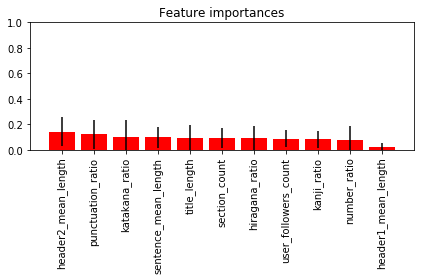

In [16]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scripts.models.save_models import SaveModels

# estimate accuracy by cross validation
clf = RandomForestClassifier(n_estimators=15, max_features=0.5)
scores = cross_val_score(clf, pf_df_n,  quality, cv=2, scoring="f1")
print(scores)

# train and show score
train_f, test_f, train_lb, test_lb = train_test_split(pf_df_n, quality, test_size=0.2, random_state=42)
clf.fit(train_f, train_lb)
pred = clf.predict(test_f)
print(classification_report(test_lb, pred, target_names=["bad", "good"]))

# show feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# save model
SaveModels(clf)

# Plot the feature importances of the forest
labels = np.array(pf_df.columns.values.tolist())
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(labels)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(labels)), labels[indices], rotation="vertical")
plt.xlim([-1, len(labels)])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()